In [1]:
import os
import torch
from datasets import Dataset, load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainerCallback
from typing import Dict
from trl import DPOTrainer, DPOConfig
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# 1. load a pretrained model and tokenizer

In [3]:
model_name_or_path = "openai-community/gpt2"
ignore_bias_buffers = False

model = AutoModelForCausalLM.from_pretrained(model_name_or_path)
if ignore_bias_buffers:
    # torch distributed hack
    model._ddp_params_and_buffers_to_ignore = [
        name for name, buffer in model.named_buffers() if buffer.dtype == torch.bool
    ]

model_ref = AutoModelForCausalLM.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

The DPO trainer expects a model of AutoModelForCausalLM, compared to PPO that expects AutoModelForCausalLMWithValueHead for the value function.

## 2. Load the Anthropic Helpful-Harmless dataset

In [4]:
def extract_anthropic_prompt(prompt_and_response):
    """Extract the anthropic prompt from a prompt and response pair."""
    search_term = "\n\nAssistant:"
    search_term_idx = prompt_and_response.rfind(search_term)
    assert search_term_idx != -1, f"Prompt and response does not contain '{search_term}'"
    return prompt_and_response[: search_term_idx + len(search_term)]

def get_hh(split: str, sanity_check: bool = False, silent: bool = False, cache_dir: str = None) -> Dataset:
    """Load the Anthropic Helpful-Harmless dataset from Hugging Face and convert it to the necessary format.

    The dataset is converted to a dictionary with the following structure:
    {
        'prompt': List[str],
        'chosen': List[str],
        'rejected': List[str],
    }

    Prompts should be structured as follows:
      \n\nHuman: <prompt>\n\nAssistant:
    Multiple turns are allowed, but the prompt should always start with \n\nHuman: and end with \n\nAssistant:.
    """

    dataset = load_dataset("Anthropic/hh-rlhf", split=split, cache_dir=cache_dir)
    if sanity_check:
        dataset = dataset.select(range(min(len(dataset), 1000)))

    def split_prompt_and_responses(sample) -> Dict[str, str]:
        prompt = extract_anthropic_prompt(sample["chosen"])
        return {
            "prompt": prompt,
            "chosen": sample["chosen"][len(prompt) :],
            "rejected": sample["rejected"][len(prompt) :],
        }

    return dataset.map(split_prompt_and_responses)

sanity_check = True
train_dataset = get_hh("train", sanity_check=sanity_check)
eval_dataset = get_hh("test", sanity_check=sanity_check)

In [5]:
train_dataset

Dataset({
    features: ['chosen', 'rejected', 'prompt'],
    num_rows: 1000
})

In [6]:
eval_dataset

Dataset({
    features: ['chosen', 'rejected', 'prompt'],
    num_rows: 1000
})

In [7]:
class LossCallback(TrainerCallback):
    def __init__(self):
        self.training_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs.get("loss") is not None:
            self.training_losses.append(logs["loss"])

# 3. initialize training arguments:

In [8]:
training_args_1 = DPOConfig(
    num_train_epochs=3,
    learning_rate=5e-7,
    per_device_train_batch_size=1,
    do_eval=True,
    per_device_eval_batch_size=1,
    adam_epsilon=1e-8,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    seed=42,
    logging_steps=100,          
    save_steps=100,
    save_strategy="steps",
    output_dir="./output-dir-1",
    gradient_checkpointing=True,
    bf16=True,
    remove_unused_columns=False,
)

# 4. initialize the DPO trainer

In [11]:
loss_callback_1 = LossCallback()
trainer_1 = DPOTrainer(
    model=model,
    ref_model=model_ref,
    args=training_args_1,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    processing_class=tokenizer,
)
trainer_1.add_callback(loss_callback_1)

# 5. Train

In [14]:
trainer_1.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
100,0.694400
200,0.690900
300,0.666000
400,0.692200
500,0.668300
600,0.641400
700,0.701200
800,0.634700
900,0.704500
1000,0.676400


TrainOutput(global_step=3000, training_loss=0.6127150751749675, metrics={'train_runtime': 3413.0115, 'train_samples_per_second': 0.879, 'train_steps_per_second': 0.879, 'total_flos': 0.0, 'train_loss': 0.6127150751749675, 'epoch': 3.0})

# 5. Visualize the loss curves

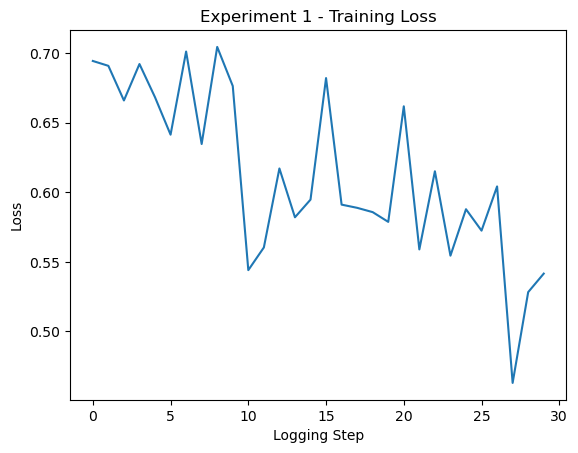

In [22]:
plt.figure()
plt.plot(loss_callback_1.training_losses)
plt.title("Experiment 1 - Training Loss")
plt.xlabel("Logging Step")
plt.ylabel("Loss")
plt.show()